[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_08_descenso_gradiente-published.ipynb)

# Descenso por gradiente

Vamos a explorar el método de descenso por gradiente para el cómputo de una regresión lineal.


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from typing import Callable, Dict, Optional, Any

#### Datos para trabajar

Tenemos los siguientes datos generados al azar para ser ajustados por una regresión.

In [3]:
bias = 500
X, y, coef = make_regression(n_samples=5000, 
                             n_features=3, 
                             bias= bias,
                             noise=1, random_state=42, coef=True)

print(f"Generamos una matriz de {X.shape[0]} de observaciones de {X.shape[1]} atributos\n" + 
      f"Target en el rango {(round(min(y),2), round(max(y),2))}\n" + 
      f"los coeficientes con los que fueron generados son: {coef}")

print(f"Y = {bias} + {' + '.join([str(round(c,2)) + ' * X' + str(idx+1) for idx,c in enumerate(coef)])} + ε")

Generamos una matriz de 5000 de observaciones de 3 atributos
Target en el rango (113.11, 865.44)
los coeficientes con los que fueron generados son: [38.95952484  1.51074456 89.82730651]
Y = 500 + 38.96 * X1 + 1.51 * X2 + 89.83 * X3 + ε


Los datos se ven así:

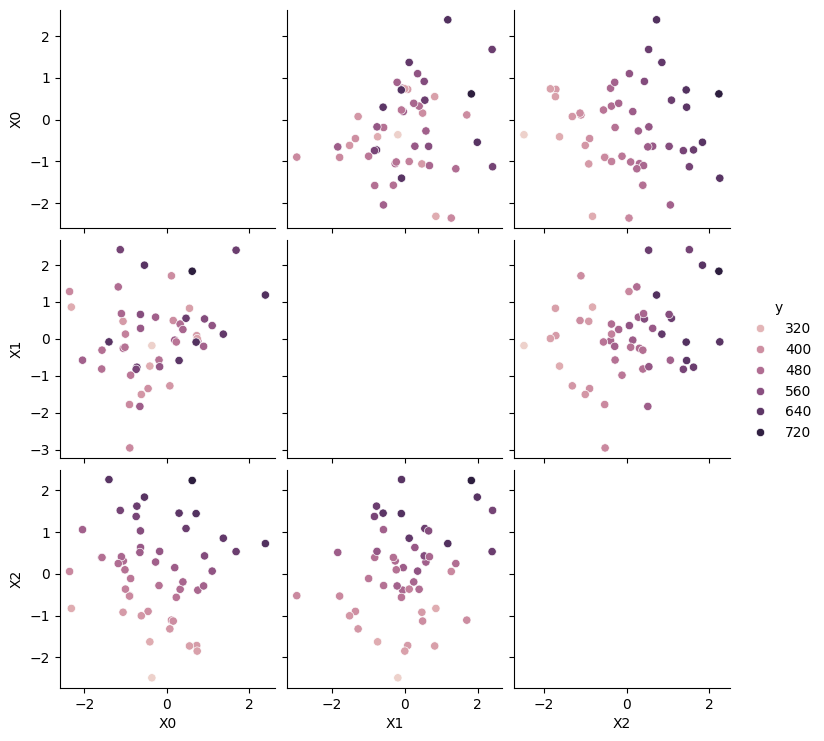

In [4]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y"] = y
sns.pairplot(df.sample(50), hue="y")

En este notebook vamos a ver el resultado calculado de diversas formas, por lo que vamos a guardar para cada resultado los w y un valor de error.

In [5]:
# Usamos esta métrica, pero podemos reemplazarla por otra

def error_prediccion(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # agrego columna para el intercept
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    
    predicciones = np.dot(X_ext, w)

    return mean_squared_error(predicciones, y)

Los resultados los almacenaremos en un `DataFrame`.

In [6]:
# Guardo los datos para comparaciones posteriores
resultados = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])

err = error_prediccion(X, y, np.array([bias] + list(coef)))
resultados.loc[len(resultados)] = ["simulacion", bias] + list(coef) + [err]
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500,38.959525,1.510745,89.827307,1.001549


## Descenso por gradiente

Veamos ahora la función general

In [7]:
def descenso_gradiente(g, dg, z_init, alpha, num_iterations, tol):
    """
    Descenso de gradiente para minimizar g. 
    Args:
        g: La función a optimizar. 
        dg: El gradiente de la función.
        z_init: Valor inicial.
        alpha: El 'learning rate'.
        num_iterations: Máx iteraciones.
        tol: Tolerancia para la convergencia. 
    """
    z = z_init
    for _ in range(num_iterations):
        gradient = dg(z) # gradient vale por ej <0.5, -0.2, -3, 0>
        z_new = z - (alpha * gradient)
        if abs(g(z_new) - g(z)) < tol:
            break
        z = z_new
    return z


Con esto es todo lo que necesitamos de descenso por gradiente.

## Regresión lineal

Podemos generarnos una clase que calcula la regresión lineal utilizando el método de  descenso por gradiente y nos devuelva los pesos correspondientes a los w de la regresión.



In [8]:
from sklearn import preprocessing
from sklearn.metrics import Strat
from functools import partial

class RegresionLinealDG():
    
    def __init__(self,
                 func_costo: Callable[..., float], 
                 func_costo_grad: Callable[..., np.ndarray], 
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False
   
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        cost_X_y = partial(self.func_costo, X=X_train_ext, y=y)
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext, y=y)       
                    
        w_shape = X_train_ext.shape[1]
        self.w = descenso_gradiente(cost_X_y, grad_cost_X_y, 
                        z_init=np.zeros(w_shape), 
                        **self.descenso_gradiente_hyperparams)


Con la clase `RegresionLinealDG` ya debemos definir en la creación la función de costo y el gradiente que se utilizan en el método (descenso por grandiente).

Empecemos usando MSE:

$MSE_{X,y} = \frac{1}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)})^2$

y su gradiente:

$\nabla_{\mathbf{w}} MSE_{X,y}(w) = \frac{2}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)}) * x^{(i)}$



In [9]:
def mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2)
 
def grad_mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y)

Podemos entonces crear nuestra regresión:

In [10]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse, grad_mse, hyperparametros)

Entrenarla:

In [11]:
reg.fit(X,y)

Y obtener los w 

In [12]:
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg.w) + [err]

(DescensoG) w [499.5  38.9   1.5  89.7]


## Solución analítica

Analogamente, podemos computar el valor analitico de los _w_ con la fórmula:

$w = (X^T X)^{-1} X^T y$

In [14]:
from numpy.linalg import inv

def minimizacion_analitica(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    X_XT_inv = inv(X_ext.T @ X_ext)
    w_analitico = (X_XT_inv @ X_ext.T) @ y

    return w_analitico

Calculemos los w:

In [15]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados


(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


# Ejercicios

1. Realizar una grilla para los hyperparámetros de la regresión:

    `{"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}` 
    
    y reportar su comportamiento.

1. Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre:
    - MSE_Ridge
    - MSE_Lasso
    - MSE_ElasticSearch
    
   Reportar los resultados en el DataFrame.
1. Modificar `RegresionLinealDG` para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.


In [22]:
best_err = np.inf
best_w = None
best_params = None
params = {"alpha": np.linspace(0, 1, 10), "num_iterations": range(1000, 5000, 1000), "tol": np.linspace(0, 1, 10)}
for alpha in params["alpha"]:
    for it in params["num_iterations"]:
        for tol in params["tol"]:
            print(alpha, it, tol)
            reg = RegresionLinealDG(mse, grad_mse, { "alpha":alpha, "num_iterations": it, "tol": tol})
            reg.fit(X,y)
            err = error_prediccion(X, y, reg.w)
            if err < best_err:
                best_err = err
                best_w = reg.w
                best_params = [alpha, it, tol]
print(best_err, best_w, best_params)

0.0 1000 0.0
0.0 1000 0.1111111111111111
0.0 1000 0.2222222222222222
0.0 1000 0.3333333333333333
0.0 1000 0.4444444444444444
0.0 1000 0.5555555555555556
0.0 1000 0.6666666666666666
0.0 1000 0.7777777777777777
0.0 1000 0.8888888888888888
0.0 1000 1.0
0.0 2000 0.0
0.0 2000 0.1111111111111111
0.0 2000 0.2222222222222222
0.0 2000 0.3333333333333333
0.0 2000 0.4444444444444444
0.0 2000 0.5555555555555556
0.0 2000 0.6666666666666666
0.0 2000 0.7777777777777777
0.0 2000 0.8888888888888888
0.0 2000 1.0
0.0 3000 0.0
0.0 3000 0.1111111111111111
0.0 3000 0.2222222222222222
0.0 3000 0.3333333333333333
0.0 3000 0.4444444444444444
0.0 3000 0.5555555555555556
0.0 3000 0.6666666666666666
0.0 3000 0.7777777777777777
0.0 3000 0.8888888888888888
0.0 3000 1.0
0.0 4000 0.0
0.0 4000 0.1111111111111111
0.0 4000 0.2222222222222222
0.0 4000 0.3333333333333333
0.0 4000 0.4444444444444444
0.0 4000 0.5555555555555556
0.0 4000 0.6666666666666666
0.0 4000 0.7777777777777777
0.0 4000 0.8888888888888888
0.0 4000 1.0


In [23]:
def mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, s: float = 1) -> float:
    return mse(w, X, y) + s * np.absolute(w).sum()
 
 
def grad_mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, s: float = 1) -> np.ndarray:
    w_non_zero = w.copy()
    w_non_zero[w_non_zero == 0] = 1
    return grad_mse(w, X, y) + s * np.sign(w_non_zero)

hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse_lasso, grad_mse_lasso, hyperparametros)
reg.fit(X,y)
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradienteLasso {hyperparametros['num_iterations']}"] + list(reg.w) + [err]
resultados

(DescensoG) w [499.   38.4   1.   89.2]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteLasso 1000,499.034800,38.385098,0.996361,89.194322,2.903239


In [33]:
class RegresionLinealDGMiniBatch():
    
    def __init__(self,
                 func_costo: Callable[..., float], 
                 func_costo_grad: Callable[..., np.ndarray],
                 num_it: int,
                 alpha: float,
                 tol: float,
                 mini_batch_p: float = 0.1,
                 mini_batch_size: int = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.collect_info = False
        self.num_it = num_it
        self.mini_batch_p = mini_batch_p
        self.mini_batch_size = mini_batch_size
        self.alpha = alpha
        self.tol = tol
   
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        generator = np.random.default_rng(42)
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))
        n = X_train_ext.shape[0]
        batch_size = self.mini_batch_size if self.mini_batch_size else np.floor(n * self.mini_batch_p)
        w_shape = X_train_ext.shape[1]
        idx = [x for x in range(n)]
        done = False
        w = np.zeros(w_shape)
        for _ in range(self.num_it):
            generator.shuffle(idx) # idx
            splits = np.array_split(idx, batch_size)
            for split in splits:
                X_split = X_train_ext[split]
                y_split = y[split]
                cost_X_y = partial(self.func_costo, X=X_split, y=y_split)
                grad_cost_X_y = partial(self.func_costo_grad, X=X_split, y=y_split)       
                gradient = grad_cost_X_y(w)
                w_new = w - (self.alpha * gradient)
                if abs(cost_X_y(w_new) - cost_X_y(w)) < self.tol:
                    done = True
                    break
                w = w_new
            if done:
                break
        self.w = w

In [34]:
hyperparametros = {"alpha": 0.01, "num_it": 1000, "tol": 0.01, "mini_batch_p": 0.1}

reg = RegresionLinealDGMiniBatch(mse, grad_mse, **hyperparametros)
reg.fit(X,y)
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradienteMiniBatch {hyperparametros['mini_batch_p']}"] + list(reg.w) + [err]
resultados

(DescensoG) w [499.   38.8   1.4  89.4]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteLasso 1000,499.034800,38.385098,0.996361,89.194322,2.903239
4,DescensoGradienteMiniBatch 0.1,499.004912,38.762739,1.440781,89.422271,2.222162
5,DescensoGradienteMiniBatch 0.1,499.004912,38.762739,1.440781,89.422271,2.222162


In [35]:
hyperparametros = {"alpha": 0.01, "num_it": 1000, "tol": 0.01, "mini_batch_size": 1}

reg = RegresionLinealDGMiniBatch(mse, grad_mse, **hyperparametros)
reg.fit(X,y)
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradienteMiniBatch {hyperparametros['mini_batch_size']}"] + list(reg.w) + [err]
resultados

(DescensoG) w [499.5  38.9   1.5  89.7]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteLasso 1000,499.034800,38.385098,0.996361,89.194322,2.903239
4,DescensoGradienteMiniBatch 0.1,499.004912,38.762739,1.440781,89.422271,2.222162
5,DescensoGradienteMiniBatch 0.1,499.004912,38.762739,1.440781,89.422271,2.222162
6,DescensoGradienteMiniBatch 1,499.531213,38.904996,1.488644,89.716010,1.252022
